### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [84]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        self.inffunc=funcin(self.criterion)
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        minind=0
        #print('zashel')
        globpor=0
        globmin=0
        let=self.inffunc(y)
        supy=np.asarray([(y==j) for j in set(y)])
        ly=y.shape[0]
        #print(let)
        for i in range(x.shape[1]):
            an=np.argsort(x[:,i])
            nx=x[an]
            ssupy=supy[:,an]
            fnsupy=np.cumsum(ssupy,axis=1)
            fnsupy2=np.cumsum(ssupy[:,::-1],axis=1)
            nsupy=np.sum(fnsupy,axis=0)
            if self.criterion=='gini':
                koe=1
                nsqupy=np.sum(fnsupy/nsupy*fnsupy/nsupy,axis=0)
                nsqupy2=np.sum(fnsupy2/(nsupy[ly-1]-nsupy[::-1])*fnsupy2/(nsupy[ly-1]-nsupy[::-1]),axis=0)
            if self.criterion=='entropy':
                koe=0
                nsqupy=np.sum(lnalog(fnsupy,nsupy),axis=0)
                nsqupy2=np.sum(lnalog(fnsupy2,nsupy[ly-1]-nsupy[::-1]),axis=0)
            if self.criterion=='clserr':
                koe=1
                nsqupy=np.max(fnsupy/nsupy,axis=0)
                nsqupy2=np.max(fnsupy2/(nsupy[ly-1]-nsupy[::-1]),axis=0)
            for j in range(1,ly-1):
                sku=nsqupy[j]
                sku2=nsqupy2[-j-1]
                l=let-j/ly*(koe-sku)-(ly-j)/ly*(koe-sku2)
                #print(l)
                #print(i,j,minind,globpor)
                if l>globmin:
                    globmin=l
                    globpor=nx[j,i]
                    minind=i
        return minind,globpor,globmin

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        #print(y.shape,x.shape)
        supy=np.asarray([(y==j) for j in set(y)])
        #print(node_id,len(supy.shape))
        fnsupy=np.sum(supy,axis=1)
        k=np.max(fnsupy)
        #print (node_id,y.shape,self.min_samples_split)
        if (self.max_depth>depth)and(y.shape[0]>=self.min_samples_split)and(k-y.shape[0]):
            numer,tresh,plugain=self.__find_threshold(x,y)
            self.impdict[numer]+=plugain
            nx1,nx2,ny1,ny2=self.__div_samples(x, y, numer, tresh)
            if not(ny1.shape[0] and ny2.shape[0]):
                #print(y)
                self.tree[node_id]=(self.__class__.LEAF_TYPE,y[0],1)
                return
            self.tree[node_id]=(self.__class__.NON_LEAF_TYPE,numer,tresh)
            self.__fit_node(nx1, ny1, 2 * node_id + 1, depth+1)
            self.__fit_node(nx2, ny2, 2 * node_id + 2, depth+1)
        else:
            maxi=0
            maxind=0
            l=np.bincount(y)
            self.tree[node_id]=(self.__class__.LEAF_TYPE,np.argmax(l),np.max(l)/y.shape[0])
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.impdict={i:0 for i in range(x.shape[1])}
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.impdict

In [85]:
def lnalog(l,k):
    m=l+~(l>0)
    m=m/k
    return m*np.log(m)

In [86]:
def ercla(y):
    l=[]
    for i in set(y):
        l.append(np.sum(y==i))
    l=np.asarray(l)
    return (1-np.max(l)/np.sum(l))

def ginii(y):
    m=0
    s=0
    l=np.bincount(y)
    #for i in set(y):
    #    k=l[i]
    #    m+=k*k
    return 1-np.sum(l*l)/(y.shape[0]*y.shape[0])

def etorp(y):
    l=[]
    for i in set(y):
        m=np.sum(y==i)
        if(m):
            l.append(m)
    l=np.asarray(l)
    return -np.sum(l/np.sum(l)*np.log(l/np.sum(l)))

def funcin(crit):
    if crit=='gini':
        return ginii
    elif crit=='clserr':
        return ercla
    elif crit=='entropy':
        return etorp
    return None

In [87]:
my_clf = MyDecisionTreeClassifier(min_samples_split=10,criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2)

In [88]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [89]:
my_clf.fit(X_train,y_train)
clf.fit(X_train,y_train)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [90]:
print(f1_score(y_pred=clf.predict(X_test), y_true=y_test,average='macro'))
print(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test,average='macro'))

0.9487179487179486
0.8885003885003885


In [91]:
my_clf.tree

{0: (0, 12, 760.0),
 1: (0, 6, 2.33),
 3: (1, 0, 1.0),
 4: (0, 12, 1035.0),
 9: (1, 0, 1.0),
 10: (0, 1, 3.88),
 21: (1, 2, 1.0),
 22: (1, 2, 0.5555555555555556),
 2: (0, 9, 4.9),
 5: (0, 1, 5.51),
 11: (1, 2, 1.0),
 12: (0, 1, 5.19),
 25: (1, 2, 1.0),
 26: (0, 1, 4.61),
 53: (1, 2, 1.0),
 54: (1, 2, 0.9032258064516129),
 6: (0, 6, 1.25),
 13: (0, 0, 13.67),
 27: (1, 1, 1.0),
 28: (0, 0, 13.49),
 57: (1, 1, 1.0),
 58: (1, 1, 0.9629629629629629),
 14: (0, 8, 1.56),
 29: (1, 1, 1.0),
 30: (0, 10, 1.05),
 61: (1, 1, 1.0),
 62: (1, 2, 0.6666666666666666)}

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [92]:
%time clf.fit(X_train, y_train)

CPU times: user 2.02 ms, sys: 1.05 ms, total: 3.07 ms
Wall time: 2.83 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [93]:
%time my_clf.fit(X_train, y_train)

CPU times: user 29.8 ms, sys: 2.01 ms, total: 31.9 ms
Wall time: 32.6 ms


/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [588]:
import pandas as pd
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [589]:
df_churn = pd.read_csv('./data/churn.csv')

In [590]:
def preproc(df_init):
    df_preproc = df_init.copy()
    
    # Удалили признаки
    df_preproc = df_preproc.drop(['State', 'Area Code', 'Phone'], axis=1)
    
    # Замена категориальных признаков
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']] = \
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']].replace({'no': 0, 'yes': 1})
    
    df_preproc.loc[:,  'Churn?'] = df_preproc.loc[:,  'Churn?'].replace({'False.': 0,
                                                                         'True.': 1})
    return df_preproc

In [591]:
df_preproc = df_churn.pipe(preproc)

In [592]:
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1].values

In [482]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [483]:
my_clf = MyDecisionTreeClassifier(criterion='entropy')

In [484]:
my_clf.fit(X_train,y_train)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [485]:
y_pred=my_clf.predict(X_test)

In [486]:
print(f1_score(y_pred,y_test,average='macro'))

0.7391966785380997


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [512]:
from sklearn.model_selection import KFold

In [513]:
kf=KFold(5)

In [516]:
s=0
for train, test in kf.split(X):
    my_clf2 = MyDecisionTreeClassifier(min_samples_split=2,criterion='clserr')
    my_clf2.fit(X[train],y[train])
    y_p=my_clf2.predict(X[test])
    s+=f1_score(y_p,y[test],average='macro')
s/=5
print(s)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


0.5923358580646791

In [517]:
s=0
for train, test in kf.split(X):
    my_clf2 = MyDecisionTreeClassifier(min_samples_split=2,criterion='gini')
    my_clf2.fit(X[train],y[train])
    y_p=my_clf2.predict(X[test])
    s+=f1_score(y_p,y[test],average='macro')
s/=5
print(s)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


0.6919652452379641


In [518]:
s=0
for train, test in kf.split(X):
    my_clf2 = MyDecisionTreeClassifier(min_samples_split=2,max_depth=6,criterion='entropy')
    my_clf2.fit(X[train],y[train])
    y_p=my_clf2.predict(X[test])
    s+=f1_score(y_p,y[test],average='macro')
s/=5
print(s)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.7372987211823586


In [594]:
res=[]
for i in range(1,50):
    l=[]
    for j in range(1,50):
        s=0
        for train, test in kf.split(X):
            my_clf2 = MyDecisionTreeClassifier(min_samples_split=i,max_depth=j,criterion='gini')
            my_clf2.fit(X[train],y[train])
            y_p=my_clf2.predict(X[test])
            s+=f1_score(y_p,y[test],average='macro')
        s/=5
        l.append(s)
        print(s,i,j)
    res.append(l)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


0.6429176950407861 1 1
0.6618678366237305 1 2
0.6611760147742085 1 3
0.6710177081821799 1 4
0.6919652452379641 1 5
0.6989049175841215 1 6
0.6874516865983423 1 7
0.6835571381270708 1 8
0.6835571381270708 1 9
0.683179649823684 1 10
0.6802425150271436 1 11
0.6802425150271436 1 12
0.6798316750184017 1 13
0.6798316750184017 1 14
0.6798316750184017 1 15
0.6798316750184017 1 16
0.6798316750184017 1 17
0.6798316750184017 1 18
0.6798316750184017 1 19
0.6798316750184017 1 20
0.6798316750184017 1 21
0.6798316750184017 1 22
0.6798316750184017 1 23
0.6798316750184017 1 24
0.6798316750184017 1 25
0.6798316750184017 1 26
0.6798316750184017 1 27
0.6798316750184017 1 28
0.6798316750184017 1 29
0.6798316750184017 1 30
0.6798316750184017 1 31
0.6798316750184017 1 32
0.6798316750184017 1 33
0.6798316750184017 1 34
0.6798316750184017 1 35
0.6798316750184017 1 36
0.6798316750184017 1 37
0.6798316750184017 1 38
0.6798316750184017 1 39
0.6798316750184017 1 40
0.6798316750184017 1 41
0.6798316750184017 1 42
0.

0.6611760147742085 8 3
0.6710177081821799 8 4
0.6919652452379641 8 5
0.6989049175841215 8 6
0.6874516865983423 8 7
0.6835571381270708 8 8
0.6835571381270708 8 9
0.683179649823684 8 10
0.6802425150271436 8 11
0.6802425150271436 8 12
0.6798316750184017 8 13
0.6798316750184017 8 14
0.6798316750184017 8 15
0.6798316750184017 8 16
0.6798316750184017 8 17
0.6798316750184017 8 18
0.6798316750184017 8 19
0.6798316750184017 8 20
0.6798316750184017 8 21
0.6798316750184017 8 22
0.6798316750184017 8 23
0.6798316750184017 8 24
0.6798316750184017 8 25
0.6798316750184017 8 26
0.6798316750184017 8 27
0.6798316750184017 8 28
0.6798316750184017 8 29
0.6798316750184017 8 30
0.6798316750184017 8 31
0.6798316750184017 8 32
0.6798316750184017 8 33
0.6798316750184017 8 34
0.6798316750184017 8 35
0.6798316750184017 8 36
0.6798316750184017 8 37
0.6798316750184017 8 38
0.6798316750184017 8 39
0.6798316750184017 8 40
0.6798316750184017 8 41
0.6798316750184017 8 42
0.6798316750184017 8 43
0.6798316750184017 8 44


0.6794243211334066 14 44
0.6794243211334066 14 45
0.6794243211334066 14 46
0.6794243211334066 14 47
0.6794243211334066 14 48
0.6794243211334066 14 49
0.6429176950407861 15 1
0.6618678366237305 15 2
0.6611760147742085 15 3
0.6710177081821799 15 4
0.6919652452379641 15 5
0.6989049175841215 15 6
0.6874516865983423 15 7
0.683142182081409 15 8
0.683142182081409 15 9
0.6827652597104257 15 10
0.6798316750184017 15 11
0.6798316750184017 15 12
0.6798316750184017 15 13
0.6798316750184017 15 14
0.6798316750184017 15 15
0.6798316750184017 15 16
0.6798316750184017 15 17
0.6798316750184017 15 18
0.6798316750184017 15 19
0.6798316750184017 15 20
0.6798316750184017 15 21
0.6798316750184017 15 22
0.6798316750184017 15 23
0.6798316750184017 15 24
0.6798316750184017 15 25
0.6798316750184017 15 26
0.6798316750184017 15 27
0.6798316750184017 15 28
0.6798316750184017 15 29
0.6798316750184017 15 30
0.6798316750184017 15 31
0.6798316750184017 15 32
0.6798316750184017 15 33
0.6798316750184017 15 34
0.679831675

0.6803433407291611 21 33
0.6803433407291611 21 34
0.6803433407291611 21 35
0.6803433407291611 21 36
0.6803433407291611 21 37
0.6803433407291611 21 38
0.6803433407291611 21 39
0.6803433407291611 21 40
0.6803433407291611 21 41
0.6803433407291611 21 42
0.6803433407291611 21 43
0.6803433407291611 21 44
0.6803433407291611 21 45
0.6803433407291611 21 46
0.6803433407291611 21 47
0.6803433407291611 21 48
0.6803433407291611 21 49
0.6429176950407861 22 1
0.6618678366237305 22 2
0.6611760147742085 22 3
0.6710177081821799 22 4
0.6885558172020745 22 5
0.6973464357189328 22 6
0.6853855601863476 22 7
0.6801940903730564 22 8
0.6801940903730564 22 9
0.6803433407291611 22 10
0.6803433407291611 22 11
0.6803433407291611 22 12
0.6803433407291611 22 13
0.6803433407291611 22 14
0.6803433407291611 22 15
0.6803433407291611 22 16
0.6803433407291611 22 17
0.6803433407291611 22 18
0.6803433407291611 22 19
0.6803433407291611 22 20
0.6803433407291611 22 21
0.6803433407291611 22 22
0.6803433407291611 22 23
0.6803433

0.6793126526207496 28 26
0.6793126526207496 28 27
0.6793126526207496 28 28
0.6793126526207496 28 29
0.6793126526207496 28 30
0.6793126526207496 28 31
0.6793126526207496 28 32
0.6793126526207496 28 33
0.6793126526207496 28 34
0.6793126526207496 28 35
0.6793126526207496 28 36
0.6793126526207496 28 37
0.6793126526207496 28 38
0.6793126526207496 28 39
0.6793126526207496 28 40
0.6793126526207496 28 41
0.6793126526207496 28 42
0.6793126526207496 28 43
0.6793126526207496 28 44
0.6793126526207496 28 45
0.6793126526207496 28 46
0.6793126526207496 28 47
0.6793126526207496 28 48
0.6793126526207496 28 49
0.6429176950407861 29 1
0.6618678366237305 29 2
0.6611760147742085 29 3
0.6710177081821799 29 4
0.6885558172020745 29 5
0.6973464357189328 29 6
0.6848619680216516 29 7
0.6796725661560519 29 8
0.6796725661560519 29 9
0.6793126526207496 29 10
0.6793126526207496 29 11
0.6793126526207496 29 12
0.6793126526207496 29 13
0.6793126526207496 29 14
0.6793126526207496 29 15
0.6793126526207496 29 16
0.6793126

0.6722931949844921 35 14
0.6722931949844921 35 15
0.6722931949844921 35 16
0.6722931949844921 35 17
0.6722931949844921 35 18
0.6722931949844921 35 19
0.6722931949844921 35 20
0.6722931949844921 35 21
0.6722931949844921 35 22
0.6722931949844921 35 23
0.6722931949844921 35 24
0.6722931949844921 35 25
0.6722931949844921 35 26
0.6722931949844921 35 27
0.6722931949844921 35 28
0.6722931949844921 35 29
0.6722931949844921 35 30
0.6722931949844921 35 31
0.6722931949844921 35 32
0.6722931949844921 35 33
0.6722931949844921 35 34
0.6722931949844921 35 35
0.6722931949844921 35 36
0.6722931949844921 35 37
0.6722931949844921 35 38
0.6722931949844921 35 39
0.6722931949844921 35 40
0.6722931949844921 35 41
0.6722931949844921 35 42
0.6722931949844921 35 43
0.6722931949844921 35 44
0.6722931949844921 35 45
0.6722931949844921 35 46
0.6722931949844921 35 47
0.6722931949844921 35 48
0.6722931949844921 35 49
0.6429176950407861 36 1
0.6618678366237305 36 2
0.6611760147742085 36 3
0.6698348827164886 36 4
0.68

0.6429176950407861 42 1
0.6618678366237305 42 2
0.6611760147742085 42 3
0.6686672397159629 42 4
0.6786288677022321 42 5
0.6874237355057364 42 6
0.6752117794323389 42 7
0.6704030645643025 42 8
0.6704030645643025 42 9
0.6700431510290003 42 10
0.6700431510290003 42 11
0.6700431510290003 42 12
0.6700431510290003 42 13
0.6700431510290003 42 14
0.6700431510290003 42 15
0.6700431510290003 42 16
0.6700431510290003 42 17
0.6700431510290003 42 18
0.6700431510290003 42 19
0.6700431510290003 42 20
0.6700431510290003 42 21
0.6700431510290003 42 22
0.6700431510290003 42 23
0.6700431510290003 42 24
0.6700431510290003 42 25
0.6700431510290003 42 26
0.6700431510290003 42 27
0.6700431510290003 42 28
0.6700431510290003 42 29
0.6700431510290003 42 30
0.6700431510290003 42 31
0.6700431510290003 42 32
0.6700431510290003 42 33
0.6700431510290003 42 34
0.6700431510290003 42 35
0.6700431510290003 42 36
0.6700431510290003 42 37
0.6700431510290003 42 38
0.6700431510290003 42 39
0.6700431510290003 42 40
0.6700431

0.6686196622900773 48 38
0.6686196622900773 48 39
0.6686196622900773 48 40
0.6686196622900773 48 41
0.6686196622900773 48 42
0.6686196622900773 48 43
0.6686196622900773 48 44
0.6686196622900773 48 45
0.6686196622900773 48 46
0.6686196622900773 48 47
0.6686196622900773 48 48
0.6686196622900773 48 49
0.6429176950407861 49 1
0.6618678366237305 49 2
0.6611760147742085 49 3
0.6667691927660365 49 4
0.6770463592730814 49 5
0.6858426729134464 49 6
0.673788290693416 49 7
0.6689795758253797 49 8
0.6689795758253797 49 9
0.6686196622900773 49 10
0.6686196622900773 49 11
0.6686196622900773 49 12
0.6686196622900773 49 13
0.6686196622900773 49 14
0.6686196622900773 49 15
0.6686196622900773 49 16
0.6686196622900773 49 17
0.6686196622900773 49 18
0.6686196622900773 49 19
0.6686196622900773 49 20
0.6686196622900773 49 21
0.6686196622900773 49 22
0.6686196622900773 49 23
0.6686196622900773 49 24
0.6686196622900773 49 25
0.6686196622900773 49 26
0.6686196622900773 49 27
0.6686196622900773 49 28
0.66861966

In [597]:
ne=np.asarray(res)

In [601]:
np.max(ne)

0.7003953531293028

In [602]:
res=[]
for i in range(1,50):
    l=[]
    for j in range(1,50):
        s=0
        for train, test in kf.split(X):
            my_clf2 = MyDecisionTreeClassifier(min_samples_split=i,max_depth=j,criterion='entropy')
            my_clf2.fit(X[train],y[train])
            y_p=my_clf2.predict(X[test])
            s+=f1_score(y_p,y[test],average='macro')
        s/=5
        l.append(s)
        print(s,i,j)
    res.append(l)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.5939127008429754 1 1
0.656583962456543 1 2
0.7005223504675483 1 3
0.7116472499317136 1 4
0.7372987211823586 1 5
0.7361517117018982 1 6
0.7376119578169529 1 7
0.7358029765292213 1 8
0.7353259974242973 1 9
0.7332275478137051 1 10
0.7332275478137051 1 11
0.7337435597436215 1 12
0.7332840105444414 1 13
0.7255177203266946 1 14
0.7255177203266946 1 15
0.7255177203266946 1 16
0.7247203384524343 1 17
0.7256890250997194 1 18
0.7256890250997194 1 19
0.7256890250997194 1 20
0.7256890250997194 1 21
0.7256890250997194 1 22
0.7256890250997194 1 23
0.7256890250997194 1 24
0.7256890250997194 1 25
0.7256890250997194 1 26
0.7256890250997194 1 27
0.7256890250997194 1 28
0.7256890250997194 1 29
0.7256890250997194 1 30
0.7256890250997194 1 31
0.7256890250997194 1 32
0.7256890250997194 1 33
0.7256890250997194 1 34
0.7256890250997194 1 35
0.7256890250997194 1 36
0.7256890250997194 1 37
0.7256890250997194 1 38
0.7256890250997194 1 39
0.7256890250997194 1 40
0.7256890250997194 1 41
0.7256890250997194 1 42
0.

0.7005223504675483 8 3
0.7116472499317136 8 4
0.7372987211823586 8 5
0.7361517117018982 8 6
0.7376119578169529 8 7
0.7353259974242973 8 8
0.7353259974242973 8 9
0.7332275478137051 8 10
0.7332275478137051 8 11
0.7337435597436215 8 12
0.7332840105444414 8 13
0.7273897109844538 8 14
0.7273897109844538 8 15
0.7273897109844538 8 16
0.7273897109844538 8 17
0.7273897109844538 8 18
0.7273897109844538 8 19
0.7273897109844538 8 20
0.7273897109844538 8 21
0.7273897109844538 8 22
0.7273897109844538 8 23
0.7273897109844538 8 24
0.7273897109844538 8 25
0.7273897109844538 8 26
0.7273897109844538 8 27
0.7273897109844538 8 28
0.7273897109844538 8 29
0.7273897109844538 8 30
0.7273897109844538 8 31
0.7273897109844538 8 32
0.7273897109844538 8 33
0.7273897109844538 8 34
0.7273897109844538 8 35
0.7273897109844538 8 36
0.7273897109844538 8 37
0.7273897109844538 8 38
0.7273897109844538 8 39
0.7273897109844538 8 40
0.7273897109844538 8 41
0.7273897109844538 8 42
0.7273897109844538 8 43
0.7273897109844538 8 44

0.7308506896523104 14 44
0.7308506896523104 14 45
0.7308506896523104 14 46
0.7308506896523104 14 47
0.7308506896523104 14 48
0.7308506896523104 14 49
0.5939127008429754 15 1
0.656583962456543 15 2
0.7005223504675483 15 3
0.7116472499317136 15 4
0.7372987211823586 15 5
0.7366362807150507 15 6
0.7376119578169529 15 7
0.735261956375918 15 8
0.735261956375918 15 9
0.7372022835955832 15 10
0.7372022835955832 15 11
0.7372022835955832 15 12
0.7367403451292087 15 13
0.7308506896523104 15 14
0.7308506896523104 15 15
0.7308506896523104 15 16
0.7308506896523104 15 17
0.7308506896523104 15 18
0.7308506896523104 15 19
0.7308506896523104 15 20
0.7308506896523104 15 21
0.7308506896523104 15 22
0.7308506896523104 15 23
0.7308506896523104 15 24
0.7308506896523104 15 25
0.7308506896523104 15 26
0.7308506896523104 15 27
0.7308506896523104 15 28
0.7308506896523104 15 29
0.7308506896523104 15 30
0.7308506896523104 15 31
0.7308506896523104 15 32
0.7308506896523104 15 33
0.7308506896523104 15 34
0.7308506896

0.7299819032848385 21 34
0.7299819032848385 21 35
0.7299819032848385 21 36
0.7299819032848385 21 37
0.7299819032848385 21 38
0.7299819032848385 21 39
0.7299819032848385 21 40
0.7299819032848385 21 41
0.7299819032848385 21 42
0.7299819032848385 21 43
0.7299819032848385 21 44
0.7299819032848385 21 45
0.7299819032848385 21 46
0.7299819032848385 21 47
0.7299819032848385 21 48
0.7299819032848385 21 49
0.5939127008429754 22 1
0.656583962456543 22 2
0.7005223504675483 22 3
0.7096735964321149 22 4
0.7341280004276037 22 5
0.7337233073884856 22 6
0.7357480713705622 22 7
0.7357480713705622 22 8
0.7357480713705622 22 9
0.7357480713705622 22 10
0.7357480713705622 22 11
0.7357480713705622 22 12
0.7352987428739566 22 13
0.7295903798061476 22 14
0.7295903798061476 22 15
0.7295903798061476 22 16
0.7295903798061476 22 17
0.7295903798061476 22 18
0.7295903798061476 22 19
0.7295903798061476 22 20
0.7295903798061476 22 21
0.7295903798061476 22 22
0.7295903798061476 22 23
0.7295903798061476 22 24
0.72959037

0.7293040689136713 28 22
0.7293040689136713 28 23
0.7293040689136713 28 24
0.7293040689136713 28 25
0.7293040689136713 28 26
0.7293040689136713 28 27
0.7293040689136713 28 28
0.7293040689136713 28 29
0.7293040689136713 28 30
0.7293040689136713 28 31
0.7293040689136713 28 32
0.7293040689136713 28 33
0.7293040689136713 28 34
0.7293040689136713 28 35
0.7293040689136713 28 36
0.7293040689136713 28 37
0.7293040689136713 28 38
0.7293040689136713 28 39
0.7293040689136713 28 40
0.7293040689136713 28 41
0.7293040689136713 28 42
0.7293040689136713 28 43
0.7293040689136713 28 44
0.7293040689136713 28 45
0.7293040689136713 28 46
0.7293040689136713 28 47
0.7293040689136713 28 48
0.7293040689136713 28 49
0.5939127008429754 29 1
0.656583962456543 29 2
0.7005223504675483 29 3
0.7096735964321149 29 4
0.7329142380356237 29 5
0.7278114471863963 29 6
0.7308309807881433 29 7
0.7308309807881433 29 8
0.7308309807881433 29 9
0.7308309807881433 29 10
0.7308309807881433 29 11
0.7308309807881433 29 12
0.73037812

0.727532176730333 35 13
0.721817047373172 35 14
0.721817047373172 35 15
0.721817047373172 35 16
0.721817047373172 35 17
0.721817047373172 35 18
0.721817047373172 35 19
0.721817047373172 35 20
0.721817047373172 35 21
0.721817047373172 35 22
0.721817047373172 35 23
0.721817047373172 35 24
0.721817047373172 35 25
0.721817047373172 35 26
0.721817047373172 35 27
0.721817047373172 35 28
0.721817047373172 35 29
0.721817047373172 35 30
0.721817047373172 35 31
0.721817047373172 35 32
0.721817047373172 35 33
0.721817047373172 35 34
0.721817047373172 35 35
0.721817047373172 35 36
0.721817047373172 35 37
0.721817047373172 35 38
0.721817047373172 35 39
0.721817047373172 35 40
0.721817047373172 35 41
0.721817047373172 35 42
0.721817047373172 35 43
0.721817047373172 35 44
0.721817047373172 35 45
0.721817047373172 35 46
0.721817047373172 35 47
0.721817047373172 35 48
0.721817047373172 35 49
0.5939127008429754 36 1
0.656583962456543 36 2
0.7005223504675483 36 3
0.7085061934048588 36 4
0.731414947261854

0.7071055945379067 42 4
0.7156225243494163 42 5
0.71286383752424 42 6
0.71286383752424 42 7
0.71286383752424 42 8
0.71286383752424 42 9
0.71286383752424 42 10
0.71286383752424 42 11
0.71286383752424 42 12
0.712408302822112 42 13
0.7066587153650492 42 14
0.7066587153650492 42 15
0.7066587153650492 42 16
0.7066587153650492 42 17
0.7066587153650492 42 18
0.7066587153650492 42 19
0.7066587153650492 42 20
0.7066587153650492 42 21
0.7066587153650492 42 22
0.7066587153650492 42 23
0.7066587153650492 42 24
0.7066587153650492 42 25
0.7066587153650492 42 26
0.7066587153650492 42 27
0.7066587153650492 42 28
0.7066587153650492 42 29
0.7066587153650492 42 30
0.7066587153650492 42 31
0.7066587153650492 42 32
0.7066587153650492 42 33
0.7066587153650492 42 34
0.7066587153650492 42 35
0.7066587153650492 42 36
0.7066587153650492 42 37
0.7066587153650492 42 38
0.7066587153650492 42 39
0.7066587153650492 42 40
0.7066587153650492 42 41
0.7066587153650492 42 42
0.7066587153650492 42 43
0.7066587153650492 42

0.7054758898993579 48 42
0.7054758898993579 48 43
0.7054758898993579 48 44
0.7054758898993579 48 45
0.7054758898993579 48 46
0.7054758898993579 48 47
0.7054758898993579 48 48
0.7054758898993579 48 49
0.5939127008429754 49 1
0.656583962456543 49 2
0.7005223504675483 49 3
0.7059227690722154 49 4
0.714439698883725 49 5
0.7116810120585487 49 6
0.7116810120585487 49 7
0.7116810120585487 49 8
0.7116810120585487 49 9
0.7116810120585487 49 10
0.7116810120585487 49 11
0.7116810120585487 49 12
0.7112254773564206 49 13
0.7054758898993579 49 14
0.7054758898993579 49 15
0.7054758898993579 49 16
0.7054758898993579 49 17
0.7054758898993579 49 18
0.7054758898993579 49 19
0.7054758898993579 49 20
0.7054758898993579 49 21
0.7054758898993579 49 22
0.7054758898993579 49 23
0.7054758898993579 49 24
0.7054758898993579 49 25
0.7054758898993579 49 26
0.7054758898993579 49 27
0.7054758898993579 49 28
0.7054758898993579 49 29
0.7054758898993579 49 30
0.7054758898993579 49 31
0.7054758898993579 49 32
0.705475889

In [605]:
np.max(res)

0.7390561049298998

In [606]:
ne2=np.asarray(res)

In [607]:
ji=[i for i in range(1,50)]

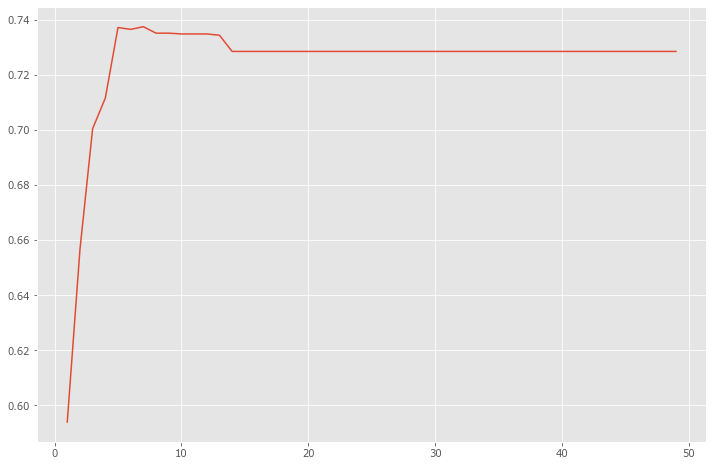

In [612]:
plt.plot(ji,ne2[11])  #max_depth

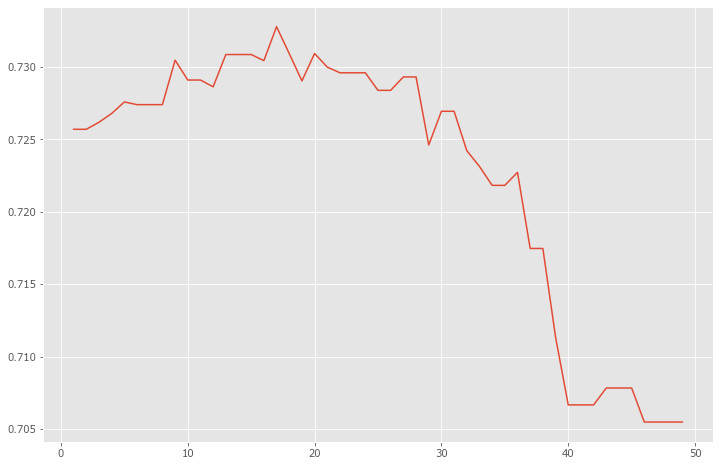

In [613]:
plt.plot(ji,ne2[:,18]) #min_samples_split

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [636]:
my_clf3 = MyDecisionTreeClassifier(criterion='entropy')

In [637]:
my_clf3.fit(X,y)

/Users/treatpetr/.conda/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [638]:
my_clf3.get_feature_importance()

{0: 0.32162651158991123,
 1: 0.23546781066341763,
 2: 0.5706093867115344,
 3: 0.181168939793937,
 4: 0.9454233901745694,
 5: 0,
 6: 0,
 7: 0.35477475044985574,
 8: 0,
 9: 0,
 10: 0.3238014444132521,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0.04327495234455527}

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [ ]:
#Короче, я вообще не знаю как еще ускорить это дерево